# モジュール準備

In [1]:
import os
import tarfile
import tqdm
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import collections
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt
import japanize_matplotlib
from gradcam.utils import visualize_cam
from torchvision.utils import make_grid

In [2]:
pd.options.display.max_columns = 200
pd.options.display.max_info_columns = 200
pd.options.display.max_info_rows = 1000
pd.options.display.max_colwidth = 200

# データ

In [ ]:
# https://qiita.com/neuzen-ryuki/items/48fa468fa0b1c502ed1eから2019.tar.xzをダウンロードし、Google Driveに置いておく

local_folder_name = 'tenho_2019'
drive_folder_path = "/content/drive/MyDrive/mahjong/tenhou" # 2019.tar.xzを置いたフォルダパス
file_name = "2019.tar.xz"

with tarfile.open(os.path.join(drive_folder_path, file_name)) as tar:
    tar.extractall("/content/tenho_2019/")

In [ ]:
folder_path = "/content/tenho_2019/2019/"
files = os.listdir(folder_path)

agari_df = pd.DataFrame()

for file in tqdm.tqdm(files):
  test = ET.parse(os.path.join(folder_path, file))
  root = test.getroot()

  for child in root:
    if child.tag=="AGARI":
      agari = pd.DataFrame(data = child.attrib, index=[0])
      agari_df = pd.concat([agari_df, agari], ignore_index=True)

100%|██████████| 1000/1000 [00:36<00:00, 27.70it/s]


In [ ]:
print(len(agari_df))
agari_df.head()

8934


,ba,hai,m,machi,ten,yaku,doraHai,who,fromWho,sc,doraHaiUra,owari,yakuman,paoWho
0,"0,0","55,59,61,74,75,104,105,106,132,133,135",52263,135,"40,2000,0","20,1",79,0,2,"250,20,250,0,250,-20,250,0",NaN,NaN,NaN,NaN
1,"1,2","1,2,24,31,34,60,61,62,85,89,95,98,103,107",NaN,107,"30,4000,0","1,1,0,1,53,1",115,3,3,"260,-21,250,-11,230,-11,240,63",102,NaN,NaN,NaN
2,"0,0","38,40,47,75,77,83,128,129,132,133,134",11849,47,"40,1500,0","20,1",118,3,3,"239,-4,239,-7,219,-4,303,15",NaN,NaN,NaN,NaN
3,"0,1","8,9,11,36,37,38,112,113,114,124,126",40490,114,"50,8000,1","29,2,28,2",49,1,1,"225,-20,232,90,215,-40,318,-20",NaN,NaN,NaN,NaN
4,"0,1","19,22,27,60,66,68,74,78,81,96,101,107,113,114",NaN,107,"40,1300,0","1,1,53,0",44,0,2,"195,23,322,0,175,-13,298,0",88,NaN,NaN,NaN


# データフレームの変換

In [5]:
def yaku_append(x):
  han = 0
  yaku_normal = x[0].split(",")
  yakulist_normal = []
  if len(yaku_normal) > 1:
    yaku_normal = [yaku_normal[i:i + 2] for i in range(0, len(yaku_normal), 2)]
    yakulist_normal = [i[0] for i in yaku_normal if i[1]!=0]
    han = sum([int(i[1]) for i in yaku_normal if i[1]!=0])
  yakulist = yakulist_normal + x[1].split(",")
  yakulist = [int(i) for i in yakulist if i!="nan"]
  return yakulist, han

In [6]:
def yaku_label(yaku_list):
  yaku = [
      # //// 一飜
      "門前清自摸和","立直","一発","槍槓","嶺上開花",
      "海底摸月","河底撈魚","平和","断幺九","一盃口",
      "自風 東","自風 南","自風 西","自風 北",
      "場風 東","場風 南","場風 西","場風 北",
      "役牌 白","役牌 發","役牌 中",
      # //// 二飜
      "両立直","七対子","混全帯幺九","一気通貫","三色同順",
      "三色同刻","三槓子","対々和","三暗刻","小三元","混老頭",
      # //// 三飜
      "二盃口","純全帯幺九","混一色",
      # //// 六飜
      "清一色",
      # //// 満貫
      "人和",
      # //// 役満
      "天和","地和","大三元","四暗刻","四暗刻単騎","字一色",
      "緑一色","清老頭","九蓮宝燈","純正九蓮宝燈","国士無双",
      "国士無双１３面","大四喜","小四喜","四槓子",
      # //// 懸賞役
      "ドラ","裏ドラ","赤ドラ"]

  yaku_label_dic = dict(zip(yaku, range(len(yaku))))
  label_yaku_dic = dict(zip(range(len(yaku)), yaku))

  # 利用する役
  yakuuse = [
    # //// 一飜
    "断幺九",
    "役牌 白","役牌 發","役牌 中",
    # //// 二飜
    "混全帯幺九","一気通貫","三色同順",
    "三色同刻","三槓子","対々和","三暗刻","小三元","混老頭",
    # //// 三飜
    "二盃口","純全帯幺九","混一色",
    # //// 六飜
    "清一色",]

  yakuuse_label_dic = dict(zip(yakuuse, range(len(yakuuse))))
  label_yakuuse_dic = dict(zip(range(len(yakuuse)), yakuuse))

  yaku_str_list = [label_yaku_dic[i] for i in yaku_list] # あがり役名リスト
  yakuuse_str_list = list(set(yaku_str_list) & set(yakuuse)) # ラベルに使うあがり役名リスト

  label_num = len(yakuuse)
  yaku_label = [0]*label_num

  yakuuse_id_list = [yakuuse_label_dic[yakuuse_str] for yakuuse_str in yakuuse_str_list]

  for yakuuse_id in yakuuse_id_list:
    yaku_label[yakuuse_id] = 1

  return yaku_label, yakuuse_str_list

In [7]:
def naki_treatment(x):
  if isinstance(x, str):
    furo_hai_id = [furo_to_hai(i) for i in x.split(",")]
    furo_hai_str = [[hai_convert_str(j) for j in i] for i in furo_hai_id]
    return sum(furo_hai_id, []), sum(furo_hai_str, [])
  else:
    return [], []

In [8]:
def hai_convert_str(id):
  id_int = int(id)
  hai = ["一", "二", "三", "四", "五", "六", "七", "八", "九", #萬子
        "①", "②", "③", "④", "⑤", "⑥", "⑦", "⑧", "⑨", #筒子
        "1", "2", "3", "4", "5", "6", "7", "8", "9", #索子
        "東", "南", "西", "北", "白", "發", "中"]
  return hai[id_int >> 2]

In [9]:
def id_convert_image(id_list):
  # unicode
  n_unique_tiles = 34
  min_tile_code_point = 126976
  zihai = list(range(min_tile_code_point, min_tile_code_point+4)) + [126982, 126981, 126980]
  manzu = list(range(126983, 126983+9))
  souzu = list(range(126992, 126992+9))
  pinzu = list(range(127001, 127001+9))

  image_id_list = manzu + pinzu + souzu +zihai

  # 天鳳
  tenho_id_list = list(range(0, n_unique_tiles))

  tenho_image_dic = dict(zip(tenho_id_list, image_id_list))
  return "".join([chr(tenho_image_dic[i]) for i in id_list])

In [10]:
def furo_to_hai(furo):
  furo = int(furo)
  if (furo & 0x0004): # 順子の場合
      pattern = (furo & 0xFC00)>>10;
      pattern = int(pattern / 3);
      color_id = int(pattern / 7);
      number = pattern % 7 + 1;
      mentsu_num = [number, number+1, number+2];
      soezi = [(furo & 0x0018)>>3, (furo & 0x0060)>>5, (furo & 0x0180)>>7]; # 牌添字1〜3を取得
      mentsu = [color_id*9*4+(i-1)*4 + j for i, j in zip(mentsu_num, soezi)]
              
  elif (furo & 0x0018): # 刻子、加槓の場合
      pattern = (furo & 0xFE00)>>9;
      pattern = int(pattern / 3);
      color_id = int(pattern / 9); 
      number = pattern % 9 + 1;
      soezi = [0, 1, 2, 3]

      if (furo & 0x0008): # 刻子
        mentsu_num = [number, number, number];
        soezi_exclude = (furo & 0x0060)>>5
        soezi.remove(soezi_exclude)
        mentsu = [color_id*9*4+(i-1)*4 + j for i, j in zip(mentsu_num, soezi)]
        
      else: # 加槓
        mentsu_num = [number, number, number, number];
        mentsu = [color_id*9*4+(i-1)*4 + j for i, j in zip(mentsu_num, soezi)]
              
  else: # 暗槓、大明槓の場合
      pattern = (furo & 0xFF00)>>8;
      pattern = int(pattern / 4);
      color_id = int(pattern / 9);
      number = pattern % 9 + 1;
      soezi = [0, 1, 2, 3]
      mentsu_num = [number, number, number, number];
      
      if (furo & 0x0003): # 大明槓
        mentsu = [color_id*9*4+(i-1)*4 + j for i, j in zip(mentsu_num, soezi)]
      else: # 暗槓
        mentsu = [color_id*9*4+(i-1)*4 + j for i, j in zip(mentsu_num, soezi)]

  mentsu_str = [str(i) for i in mentsu]
  return mentsu_str;

In [11]:
agari_df["yaku"] = agari_df.yaku.astype('str')
agari_df["yakuman"] = agari_df.yakuman.astype('str')

agari_df["hai"] = agari_df.hai.apply(lambda x: x.split(","))

agari_df["menzen_int"] = agari_df.hai.apply(lambda x: [int(i) for i in x])
agari_df["menzen_str"] = agari_df.hai.apply(lambda x: [hai_convert_str(i) for i in x])

agari_df["furo_int"] = agari_df.m.apply(lambda x: [int(i) for i in naki_treatment(x)[0]])
agari_df["furo_str"] = agari_df.m.apply(lambda x: naki_treatment(x)[1])

agari_df["yaku_all"] = agari_df[["yaku", "yakuman"]].apply(lambda x: yaku_append(x)[0], axis=1)
agari_df["yaku_label"] = agari_df.yaku_all.apply(lambda x: yaku_label(x)[0]) # 役（対象のみ）のone-hot
agari_df["yaku_label_str"] = agari_df.yaku_all.apply(lambda x: yaku_label(x)[1]) # 役（対象のみ）
agari_df["yaku_label_num"] = agari_df.yaku_label_str.apply(len) # 役の数

agari_df["tehai_int"] = agari_df[["menzen_int", "furo_int"]].apply(lambda x: sorted([int(i) for i in x[1]+x[0]]), axis=1)
agari_df["tehai_str"] = agari_df.tehai_int.apply(lambda x: [hai_convert_str(i) for i in x])
agari_df["tehai_c_int"] = agari_df.tehai_int.apply(lambda x: sorted([id_int >> 2 for id_int in x]))
agari_df["tehai_im"] = agari_df.tehai_c_int.apply(lambda x: id_convert_image(x))

In [12]:
agari_df.head(1)

,ba,hai,m,machi,ten,yaku,doraHai,who,fromWho,sc,oya,doraHaiUra,owari,yakuman,paoWho,menzen_int,menzen_str,furo_int,furo_str,yaku_all,yaku_label,yaku_label_str,yaku_label_num,tehai_int,tehai_str,tehai_c_int,tehai_im
0,"1,0","[8, 10, 11, 56, 57, 59, 61, 65, 71, 104, 107]",41546,8,"30,1000,0","14,1",126,2,0,"265,-13,235,0,265,13,235,0",0,NaN,NaN,nan,NaN,"[8, 10, 11, 56, 57, 59, 61, 65, 71, 104, 107]","[三, 三, 三, ⑥, ⑥, ⑥, ⑦, ⑧, ⑨, 9, 9]","[108, 109, 111]","[東, 東, 東]",[14],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[],0,"[8, 10, 11, 56, 57, 59, 61, 65, 71, 104, 107, 108, 109, 111]","[三, 三, 三, ⑥, ⑥, ⑥, ⑦, ⑧, ⑨, 9, 9, 東, 東, 東]","[2, 2, 2, 14, 14, 14, 15, 16, 17, 26, 26, 27, 27, 27]",🀉🀉🀉🀞🀞🀞🀟🀠🀡🀘🀘🀀🀀🀀


## 役ラベルが1個以上ある

In [13]:
agari_df = agari_df[agari_df.yaku_label_num!=0].reset_index()
len(agari_df)

111049

In [14]:
agari_df[["yaku_label", "yaku_label_str", "tehai_str", "tehai_c_int", "tehai_im"]].head(5)

,yaku_label,yaku_label_str,tehai_str,tehai_c_int,tehai_im
0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[役牌 白],"[三, 四, 五, 六, 七, 八, 九, 九, ④, ⑤, ⑥, 白, 白, 白]","[2, 3, 4, 5, 6, 7, 8, 8, 12, 13, 14, 31, 31, 31]",🀉🀊🀋🀌🀍🀎🀏🀏🀜🀝🀞🀆🀆🀆
1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[役牌 中],"[三, 三, 三, 五, 六, 七, 2, 2, 6, 7, 8, 中, 中, 中]","[2, 2, 2, 4, 5, 6, 19, 19, 23, 24, 25, 33, 33, 33]",🀉🀉🀉🀋🀌🀍🀑🀑🀕🀖🀗🀄🀄🀄
2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[役牌 發],"[③, ④, ⑤, ⑤, ⑤, 2, 3, 4, 西, 西, 西, 發, 發, 發]","[11, 12, 13, 13, 13, 19, 20, 21, 29, 29, 29, 32, 32, 32]",🀛🀜🀝🀝🀝🀑🀒🀓🀂🀂🀂🀅🀅🀅
3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[役牌 中],"[八, 八, ①, ②, ③, 7, 8, 9, 南, 南, 南, 中, 中, 中]","[7, 7, 9, 10, 11, 24, 25, 26, 28, 28, 28, 33, 33, 33]",🀎🀎🀙🀚🀛🀖🀗🀘🀁🀁🀁🀄🀄🀄
4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[断幺九],"[五, 六, 七, ②, ③, ④, ⑧, ⑧, 3, 3, 3, 4, 4, 4]","[4, 5, 6, 10, 11, 12, 16, 16, 20, 20, 20, 21, 21, 21]",🀋🀌🀍🀚🀛🀜🀠🀠🀒🀒🀒🀓🀓🀓


## 手牌の組み合わせ

In [15]:
print(len(agari_df))
print(agari_df.tehai_c_int.apply(lambda x: str(x)).nunique())

111049
93033


# モデル（分類）-手役

## CNN

In [16]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, agari_df):
    self.tehai_list = agari_df["tehai_c_int"].tolist()
    self.yaku_label_list = agari_df["yaku_label"].tolist()

  def __len__(self):
    return len(self.tehai_list)

  def __getitem__(self, index):
    tehai, yaku_label = self.pull_item(index)
    return tehai, yaku_label

  def tehai_2d(self, tehai):
    c = collections.Counter(tehai)
    tehai_ar = np.zeros(4*9*4)
    for i in c.items():
      hai_id = i[0] # 牌の種類 0index
      hai_times = i[1] # 枚数
      hai_id_list = [hai_id*4+i for i in range(hai_times)]
      for j in hai_id_list:
        tehai_ar[j] = 1
    tehai_m = tehai_ar[0:9*1*4].copy().reshape([-1, 4])
    tehai_p = tehai_ar[9*1*4:9*2*4].copy().reshape([-1, 4])
    tehai_s = tehai_ar[9*2*4:9*3*4].copy().reshape([-1, 4])
    tehai_z = tehai_ar[9*3*4:].copy().reshape([-1, 4])
    tehai_ar = np.concatenate([tehai_m, tehai_p, tehai_s, tehai_z], 1)
    return tehai_ar

  def pull_item(self, index):
    tehai = self.tehai_list[index]
    yaku_label = self.yaku_label_list[index]
    tehai_all = torch.tensor(np.array([self.tehai_2d(tehai)]), 
                             dtype=torch.float32, device=DEVICE)
    yaku_label = torch.tensor(np.array(yaku_label), dtype=torch.float32, device=DEVICE)

    return tehai_all, yaku_label

In [17]:
BATCH_SIZE = 1024
TRAIN_SIZE = int(len(agari_df)//(BATCH_SIZE*10)*(BATCH_SIZE*10)*0.6)
VALID_SIZE = int(len(agari_df)//(BATCH_SIZE*10)*(BATCH_SIZE*10)*0.3)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df_train, df_val = train_test_split(agari_df, train_size=TRAIN_SIZE)
df_val, df_test = train_test_split(df_val, train_size=VALID_SIZE)

train_dataset = MyDataset(df_train)
val_dataset = MyDataset(df_val)
test_dataset = MyDataset(df_test)

In [18]:
# データローダーの作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,)

In [24]:
WEIGHT_DECAY = 0.005
LEARNING_RATE = 0.01
EPOCH = 100
LABEL_NUM = len(agari_df.yaku_label[0])

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2, padding=1) # 第1引数はその入力のチャネル数,第2引数は畳み込み後のチャネル数,第3引数は畳み込みをするための正方形フィルタ(カーネルとも言う)の1辺のサイズ
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, padding=1)

        self.fc1 = nn.Linear(6336, 120) # ここのin_featuresはここまでのカーネルサイズなどに左右される
        self.fc2 = nn.Linear(120, LABEL_NUM)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.view(x.size()[0], -1)
        # print(x.size()) # fc1のin_featuresを調べる
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def pred_acc(original, predicted):
    label_predicted = (predicted > 0).int()
    return label_predicted.eq(original).sum().numpy()/len(original)

net = Net()
net = net.to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)

train_loss_value=[]      #trainingのlossを保持するlist
train_acc_value=[]       #trainingのaccuracyを保持するlist
test_loss_value=[]       #testのlossを保持するlist
test_acc_value=[]        #testのaccuracyを保持するlist 

for epoch in range(EPOCH):
    print('epoch', epoch+1)    #epoch数の出力
    for (inputs, labels) in train_dataloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    running_loss = []
    running_acc = []

    #train dataを使ってテストをする(パラメータ更新がないようになっている)
    for (inputs, labels) in train_dataloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)
        acc_ = []

        for j, d in enumerate(outputs): # ミニバッチの中の一個を呼び出してる
            acc = pred_acc(torch.Tensor.cpu(labels[j]), torch.Tensor.cpu(d))
            acc_.append(acc)

        loss = criterion(outputs, labels)
        running_loss.append(loss.item()) #tensorを普通の値に
        running_acc.append(np.asarray(acc_).mean())

    total_batch_loss = np.asarray(running_loss).mean()
    total_batch_acc = np.asarray(running_acc).mean()

    print("train mean loss={}, accuracy={}"
            .format(total_batch_loss, total_batch_acc))  #lossとaccuracy出力
    train_loss_value.append(total_batch_loss)  #traindataのlossをグラフ描画のためにlistに保持
    train_acc_value.append(total_batch_acc)   #traindataのaccuracyをグラフ描画のためにlistに保持

    running_loss_test = []
    running_acc_test = []

    #valid dataを使ってテストをする
    for (inputs, labels) in val_dataloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)
        acc_ = []

        for j, d in enumerate(outputs):
             acc = pred_acc(torch.Tensor.cpu(labels[j]), torch.Tensor.cpu(d))
             acc_.append(acc)

        loss = criterion(outputs, labels)
        running_loss_test.append(loss.item())                            #lossを足していく
        running_acc_test.append(np.asarray(acc_).mean())

    total_batch_loss = np.asarray(running_loss_test).mean()
    total_batch_acc = np.asarray(running_acc_test).mean()
    
    print("test mean loss={}, accuracy={}"
            .format(total_batch_loss, total_batch_acc))  #lossとaccuracy出力
    test_loss_value.append(total_batch_loss)  #traindataのlossをグラフ描画のためにlistに保持
    test_acc_value.append(total_batch_acc)   #traindataのaccuracyをグラフ描画のためにlistに保持

epoch 1
train mean loss=0.18040778736273447, accuracy=0.933295036764706
test mean loss=0.18021653791268666, accuracy=0.9331571691176471
epoch 2
train mean loss=0.17650370722015699, accuracy=0.933295036764706
test mean loss=0.17616771111885707, accuracy=0.9331571691176471
epoch 3
train mean loss=0.1755347579717636, accuracy=0.9332950367647058
test mean loss=0.1752042387922605, accuracy=0.9331571691176471
epoch 4
train mean loss=0.1744222991168499, accuracy=0.9332950367647058
test mean loss=0.17410132388273875, accuracy=0.9331571691176471
epoch 5
train mean loss=0.17295230701565742, accuracy=0.9332950367647058
test mean loss=0.17263917376597723, accuracy=0.9331571691176471
epoch 6
train mean loss=0.1707045873006185, accuracy=0.9337536381740198
test mean loss=0.17035096138715744, accuracy=0.9335956648284314
epoch 7
train mean loss=0.16723062296708424, accuracy=0.9398581112132354
test mean loss=0.16686508109172185, accuracy=0.939725030637255
epoch 8
train mean loss=0.1615262302259604, accu

Text(0.5, 1.0, 'accuracy')

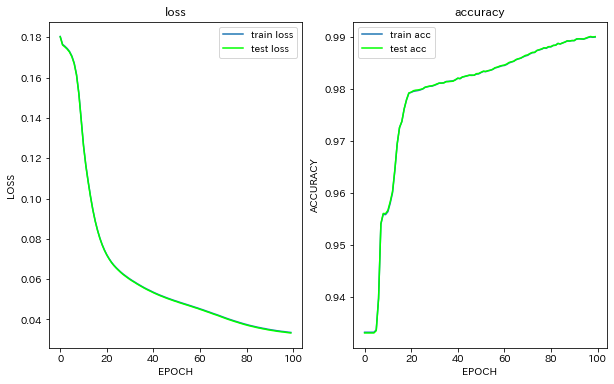

In [25]:
fig = plt.figure(figsize=(10.0, 6.0))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(range(EPOCH), train_loss_value)
ax1.plot(range(EPOCH), test_loss_value, c='#00ff00')
ax1.set_xlabel('EPOCH')
ax1.set_ylabel('LOSS')
ax1.legend(['train loss', 'test loss'])
ax1.set_title('loss')

ax2.plot(range(EPOCH), train_acc_value)
ax2.plot(range(EPOCH), test_acc_value, c='#00ff00')
ax2.set_xlabel('EPOCH')
ax2.set_ylabel('ACCURACY')
ax2.legend(['train acc', 'test acc'])
ax2.set_title('accuracy')

## データの予測

In [26]:
predicted_label_list = []

def pred_acc_test(original, predicted):
    label_predicted = (predicted > 0).int()
    return label_predicted.eq(original).sum().numpy()/len(original), list(label_predicted.detach().numpy())

for (inputs, labels) in test_dataloader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    optimizer.zero_grad()
    outputs = net(inputs)
    acc_ = []

    for j, d in enumerate(outputs):
          acc, predicted_label = pred_acc_test(torch.Tensor.cpu(labels[j]), torch.Tensor.cpu(d))
          acc_.append(acc)
          predicted_label_list.append(predicted_label)

    loss = criterion(outputs, labels)
    running_loss_test.append(loss.item())                            #lossを足していく
    running_acc_test.append(np.asarray(acc_).mean())

total_batch_loss = np.asarray(running_loss_test).mean()
total_batch_acc = np.asarray(running_acc_test).mean()

print("test mean loss={}, accuracy={}"
        .format(total_batch_loss, total_batch_acc))  #lossとaccuracy出力
test_loss_value.append(total_batch_loss)  #traindataのlossをグラフ描画のためにlistに保持
test_acc_value.append(total_batch_acc)   #traindataのaccuracyをグラフ描画のためにlistに保持

test mean loss=0.033513370711280376, accuracy=0.9900426133938258


In [27]:
# 利用する役
yakuuse_str = [
  # //// 一飜
  "断幺九",
  "役牌 白","役牌 發","役牌 中",
  # //// 二飜
  "混全帯幺九","一気通貫","三色同順",
  "三色同刻","三槓子","対々和","三暗刻","小三元","混老頭",
  # //// 三飜
  "二盃口","純全帯幺九","混一色",
  # //// 六飜
  "清一色",]

yaku_use_label_dic = dict(zip(yakuuse_str, range(len(yakuuse_str))))
label_yaku_use_dic = dict(zip(range(len(yakuuse_str)), yakuuse_str))

predicted_label_str_list = []
for predicted_label in predicted_label_list:
  predicted_label_str = [label_yaku_use_dic[i] for i, j in enumerate(predicted_label) if j!=0]
  predicted_label_str_list.append(predicted_label_str)

df_test["yaku_label_str_pre"] = predicted_label_str_list

In [28]:
df_test[["yaku_label_str", "yaku_label_str_pre", "tehai_str", "tehai_im"]].head(10)

,yaku_label_str,yaku_label_str_pre,tehai_str,tehai_im
61440,[役牌 白],[役牌 白],"[④, ⑤, ⑤, ⑥, ⑥, ⑦, 1, 1, 2, 3, 4, 白, 白, 白]",🀜🀝🀝🀞🀞🀟🀐🀐🀑🀒🀓🀆🀆🀆
21430,[役牌 白],[役牌 白],"[五, 六, 七, ⑤, ⑥, ⑦, 1, 2, 3, 白, 白, 白, 中, 中]",🀋🀌🀍🀝🀞🀟🀐🀑🀒🀆🀆🀆🀄🀄
23483,[役牌 發],[役牌 發],"[一, 一, 七, 七, 七, ③, ④, ⑤, ⑦, ⑧, ⑨, 發, 發, 發]",🀇🀇🀍🀍🀍🀛🀜🀝🀟🀠🀡🀅🀅🀅
18177,[断幺九],[断幺九],"[二, 二, 三, 三, 四, 四, ②, ②, ②, ③, ④, ⑤, ⑥, ⑦]",🀈🀈🀉🀉🀊🀊🀚🀚🀚🀛🀜🀝🀞🀟
77966,[断幺九],[断幺九],"[二, 二, 二, 六, 七, 八, ②, ②, ②, ⑧, ⑧, ⑧, 8, 8]",🀈🀈🀈🀌🀍🀎🀚🀚🀚🀠🀠🀠🀗🀗
87233,[断幺九],[断幺九],"[六, 七, 八, ②, ③, ④, 2, 2, 2, 4, 5, 6, 8, 8]",🀌🀍🀎🀚🀛🀜🀑🀑🀑🀓🀔🀕🀗🀗
15771,[役牌 白],[役牌 白],"[三, 四, 五, 九, 九, ①, ②, ③, 4, 5, 6, 白, 白, 白]",🀉🀊🀋🀏🀏🀙🀚🀛🀓🀔🀕🀆🀆🀆
89987,[断幺九],[断幺九],"[三, 四, 五, 七, 七, ⑤, ⑥, ⑥, ⑦, ⑦, ⑧, 2, 3, 4]",🀉🀊🀋🀍🀍🀝🀞🀞🀟🀟🀠🀑🀒🀓
34081,[断幺九],[断幺九],"[四, 四, 八, 八, 八, ⑥, ⑦, ⑧, 3, 4, 4, 5, 5, 6]",🀊🀊🀎🀎🀎🀞🀟🀠🀒🀓🀓🀔🀔🀕
110772,[断幺九],[断幺九],"[二, 二, 六, 七, 八, ②, ③, ④, ⑥, ⑦, ⑧, 4, 5, 6]",🀈🀈🀌🀍🀎🀚🀛🀜🀞🀟🀠🀓🀔🀕
